In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import malaya_speech
from malaya_speech.train.model import leaf 
import tensorflow as tf






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
X = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'X_placeholder')
X_len = tf.compat.v1.placeholder(tf.int32, [None], name = 'X_len_placeholder')

In [5]:
leaf_featurizer = leaf.Model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
training = True
batch_size = tf.shape(X)[0]
features = tf.TensorArray(dtype = tf.float32, size = batch_size, dynamic_size = True, infer_shape = False)
features_len = tf.TensorArray(dtype = tf.int32, size = batch_size)

init_state = (0, features, features_len)

def condition(i, features, features_len):
    return i < batch_size

def body(i, features, features_len):
    x = X[i, :X_len[i]]
    f = leaf_featurizer(tf.expand_dims(x, 0), training = training)
    f = f[0]
    warped = malaya_speech.augmentation.spectrogram.tf_warp_time(f)
    masked = malaya_speech.augmentation.spectrogram.tf_mask_frequency(warped, F = 12)
    casted_len = tf.cast(tf.cast(tf.shape(masked)[0], tf.float32) * 0.05, tf.int32)
    f = malaya_speech.augmentation.spectrogram.tf_mask_time(masked, T = casted_len)
    f_len = tf.shape(f)[0]
    return i + 1, features.write(i, f), features_len.write(i, f_len)

_, features, features_len = tf.while_loop(condition, body, init_state)
features_len = features_len.stack()
padded_features = tf.TensorArray(dtype = tf.float32, size = batch_size)
padded_lens = tf.TensorArray(dtype = tf.int32, size = batch_size)
maxlen = tf.reduce_max(features_len)

init_state = (0, padded_features, padded_lens)

def condition(i, padded_features, padded_lens):
    return i < batch_size

def body(i, padded_features, padded_lens):
    f = features.read(i)
    len_f = tf.shape(f)[0]
    f = tf.pad(f, [[0, maxlen - tf.shape(f)[0]], [0,0]])
    return i + 1, padded_features.write(i, f), padded_lens.write(i, len_f)

_, padded_features, padded_lens = tf.while_loop(condition, body, init_state)
padded_features = padded_features.stack()
padded_lens = padded_lens.stack()
padded_lens.set_shape((None))
padded_features.set_shape((None, None, 80))
padded_features = tf.expand_dims(padded_features, -1)
padded_features, padded_lens


Instructions for updating:
Use `tf.cast` instead.


(<tf.Tensor 'ExpandDims:0' shape=(?, ?, 80, 1) dtype=float32>,
 <tf.Tensor 'TensorArrayStack_2/TensorArrayGatherV3:0' shape=(?,) dtype=int32>)

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
x, sr = malaya_speech.load('../speech/example-speaker/husein-zolkepli.wav')
len(x), sr

(90090, 16000)

In [9]:
x1, sr = malaya_speech.load('../speech/example-speaker/shafiqah-idayu.wav')
len(x1), sr

(56298, 16000)

In [10]:
xs, lens = malaya_speech.padding.sequence_1d([x, x1], return_len = True)
lens

[90090, 56298]

In [11]:
o = sess.run([padded_features, padded_lens], feed_dict = {X: xs, X_len: lens})
o[0].shape, o[1]

((2, 564, 80, 1), array([564, 352], dtype=int32))

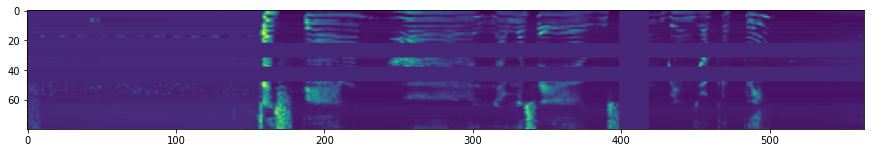

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 5))
plt.imshow(o[0][0,:,:,0].T)

In [13]:
tf.trainable_variables()

[<tf.Variable 'kernel:0' shape=(80, 2) dtype=float32>,
 <tf.Variable 'while/leaf/tfbanks_preemp/kernel:0' shape=(2, 1, 1) dtype=float32>,
 <tf.Variable 'while/leaf/learnable_pooling/kernel:0' shape=(1, 1, 80, 1) dtype=float32>,
 <tf.Variable 'while/leaf/PCEN/alpha:0' shape=(80,) dtype=float32>,
 <tf.Variable 'while/leaf/PCEN/delta:0' shape=(80,) dtype=float32>,
 <tf.Variable 'while/leaf/PCEN/root:0' shape=(80,) dtype=float32>,
 <tf.Variable 'while/leaf/PCEN/EMA/smooth:0' shape=(80,) dtype=float32>,
 <tf.Variable 'while/leaf/tfbanks_instancenorm/gamma:0' shape=(80,) dtype=float32>,
 <tf.Variable 'while/leaf/tfbanks_instancenorm/beta:0' shape=(80,) dtype=float32>]